In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-price/1553768847-housing.csv


In [2]:
df = pd.read_csv("/kaggle/input/house-price/1553768847-housing.csv")
is_missing_attr = df.isna()
n_missing_attr = is_missing_attr.sum(axis=1)
df[n_missing_attr > 0]





,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
290,-122.16,37.77,47,1256,NaN,570,218,4.3750,NEAR BAY,161900
341,-122.17,37.75,38,992,NaN,732,259,1.6196,NEAR BAY,85100
538,-122.28,37.78,29,5154,NaN,3741,1273,2.5762,NEAR BAY,173400
563,-122.24,37.75,45,891,NaN,384,146,4.9489,NEAR BAY,247100
696,-122.10,37.69,41,746,NaN,387,161,3.9063,NEAR BAY,178400
...,...,...,...,...,...,...,...,...,...,...
20267,-119.19,34.20,18,3620,NaN,3171,779,3.3409,NEAR OCEAN,220500
20268,-119.18,34.19,19,2393,NaN,1938,762,1.6953,NEAR OCEAN,167400
20372,-118.88,34.17,15,4260,NaN,1701,669,5.1033,<1H OCEAN,410700
20460,-118.75,34.29,17,5512,NaN,2734,814,6.6073,<1H OCEAN,258100


In [3]:
df.dropna(inplace=True)
df


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,-122.23,37.88,41,880,129.0,322,126,8.3252,NEAR BAY,452600
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,NEAR BAY,358500
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,NEAR BAY,352100
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,NEAR BAY,341300
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,NEAR BAY,342200
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25,1665,374.0,845,330,1.5603,INLAND,78100
20636,-121.21,39.49,18,697,150.0,356,114,2.5568,INLAND,77100
20637,-121.22,39.43,17,2254,485.0,1007,433,1.7000,INLAND,92300
20638,-121.32,39.43,18,1860,409.0,741,349,1.8672,INLAND,84700


# shuffling DS

In [4]:
shuffled = df.sample(frac=1, random_state=1).reset_index(drop=True)
shuffled

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,-118.18,34.14,38,3039,487.0,1131,465,7.7116,<1H OCEAN,360900
1,-118.19,34.14,38,1826,300.0,793,297,5.2962,<1H OCEAN,291500
2,-117.25,33.20,10,2050,473.0,1302,471,2.7961,<1H OCEAN,131300
3,-119.23,34.19,16,5297,810.0,1489,667,6.4522,NEAR OCEAN,500001
4,-120.93,39.96,15,1666,351.0,816,316,2.9559,INLAND,118800
...,...,...,...,...,...,...,...,...,...,...
20428,-117.88,33.79,32,1484,295.0,928,295,5.1418,<1H OCEAN,190300
20429,-120.43,34.70,26,2353,389.0,1420,389,3.8700,NEAR OCEAN,125800
20430,-118.45,34.08,52,1500,176.0,384,145,7.1576,<1H OCEAN,500001
20431,-116.97,33.94,29,3197,632.0,1722,603,3.0432,INLAND,91200


# splitting

In [5]:

from sklearn.model_selection import train_test_split

trainval, test = train_test_split(shuffled, test_size=0.16, shuffle=False)
train, val = train_test_split(trainval, test_size=0.2, shuffle=False)


df_target_train = train['median_house_value']
train.drop("median_house_value",axis=1,inplace=True)

df_target_test = test['median_house_value']
test.drop("median_house_value",axis=1,inplace=True)

df_target_val = val['median_house_value']
val.drop("median_house_value",axis=1,inplace=True)

In [6]:
len(test),len(train),len(val)

(3270, 13730, 3433)

# Normaling dataset
splitting data in categorical, ordinal and continuous

In [7]:
display(train)
contin_attr = ["housing_median_age","total_rooms","total_bedrooms","population","households","median_income"]
cate_attr = ["ocean_proximity"]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-118.18,34.14,38,3039,487.0,1131,465,7.7116,<1H OCEAN
1,-118.19,34.14,38,1826,300.0,793,297,5.2962,<1H OCEAN
2,-117.25,33.20,10,2050,473.0,1302,471,2.7961,<1H OCEAN
3,-119.23,34.19,16,5297,810.0,1489,667,6.4522,NEAR OCEAN
4,-120.93,39.96,15,1666,351.0,816,316,2.9559,INLAND
...,...,...,...,...,...,...,...,...,...
13725,-117.15,34.07,15,1852,316.0,906,298,5.3526,INLAND
13726,-117.42,33.35,14,25135,4819.0,35682,4769,2.5729,<1H OCEAN
13727,-118.02,33.79,23,6368,1030.0,3281,1001,6.1142,<1H OCEAN
13728,-122.03,37.83,24,5948,738.0,1997,710,9.8708,NEAR BAY


# Normalizing continious values

In [8]:
import torch
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [9]:
dataset = {"train":None, "test":None, "val":None}

scaler = StandardScaler()
encoder = OneHotEncoder(sparse=False)

# Fit the scaler on the training data
scaler.fit(train[contin_attr])

encoder = OneHotEncoder(sparse=False)


def normalizing(df): 
    return scaler.transform(df)

def encoding(df):
    return encoder.fit_transform(df)

In [10]:
train_cont = pd.DataFrame(normalizing(train[contin_attr])) 
train_cat = pd.DataFrame(encoding(train[cate_attr]))
dataset["train"] = pd.concat([train_cont,train_cat],axis=1)

test_cont = pd.DataFrame(normalizing(test[contin_attr])) 
test_cat = pd.DataFrame(encoding(test[cate_attr]))
dataset["test"] = pd.concat([test_cont,test_cat],axis=1)

val_cont = pd.DataFrame(normalizing(val[contin_attr])) 
val_cat = pd.DataFrame(encoding(val[cate_attr]))
dataset["val"] = pd.concat([val_cont,val_cat],axis=1)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [11]:
len(dataset["train"]),len(dataset["test"]),len(dataset["val"])

(13730, 3270, 3433)

# dataset

In [12]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np


In [13]:
# Convert numpy arrays to PyTorch tensors
features_tensor = torch.tensor(dataset["train"].to_numpy(),dtype=torch.float32)
target_tensor = torch.tensor(df_target_train.to_numpy(),dtype=torch.float32)


In [14]:
tensor_dataset = TensorDataset(features_tensor, target_tensor)
dataloader = DataLoader(tensor_dataset, batch_size=16, shuffle=True)



In [15]:
# Step 4: Iterate through the DataLoader
for batch_features, batch_targets in dataloader:
    print("Batch features:", batch_features)
    print("Batch targets:", batch_targets)
    break  # Just to show the first batch


Batch features: tensor([[-1.7942, -0.4907,  0.1412,  1.4994,  0.3370, -0.4955,  1.0000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [-0.4460,  1.5987,  1.3963,  1.2045,  1.5000,  0.6153,  1.0000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [ 0.4264, -0.3583, -0.6309, -0.7709, -0.6191,  0.1058,  1.0000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [ 0.1091, -0.0507, -0.1785, -0.3232, -0.2131,  1.2813,  1.0000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [ 0.9022, -0.0430, -0.1454, -0.1332, -0.0166, -0.4852,  0.0000,  0.0000,
          0.0000,  1.0000,  0.0000],
        [ 0.9022, -0.7105, -0.5243, -0.2981, -0.5955, -1.1309,  1.0000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [ 1.8539, -0.4279, -0.0933, -0.4134, -0.1712, -1.4256,  0.0000,  0.0000,
          0.0000,  0.0000,  1.0000],
        [-0.2081,  1.3411,  0.9345,  1.2105,  1.1490,  1.4075,  1.0000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [ 0.8229, -0.8574, -0.7682, -0.4

# Linear Regression

In [16]:
import torch.nn as nn

torch.manual_seed(13)
linear = nn.Linear(in_features=11, out_features=1, bias=True)

model = nn.Sequential()
model.add_module('layer1', linear)
model.state_dict(),list(model.parameters())


(OrderedDict([('layer1.weight',
               tensor([[-0.2461, -0.0124,  0.1873, -0.2924, -0.2923,  0.0625, -0.1617,  0.2191,
                         0.2930, -0.1824, -0.2515]])),
              ('layer1.bias', tensor([-0.0450]))]),
 [Parameter containing:
  tensor([[-0.2461, -0.0124,  0.1873, -0.2924, -0.2923,  0.0625, -0.1617,  0.2191,
            0.2930, -0.1824, -0.2515]], requires_grad=True),
  Parameter containing:
  tensor([-0.0450], requires_grad=True)])

In [17]:
bad_predictions = model(batch_features)
bad_predictions

tensor([[-0.3005],
        [-0.6075],
        [-0.0124],
        [-0.0296],
        [-0.4627],
        [-0.3276],
        [-0.6831],
        [-0.5991],
        [-0.2511],
        [-0.1661],
        [ 0.2490],
        [ 0.3506],
        [ 0.7183],
        [ 0.0194],
        [-0.1332],
        [ 0.2573]], grad_fn=<AddmmBackward0>)

In [18]:
bad_predictions - batch_targets


tensor([[-123200.2969, -232600.2969, -500001.3125, -460400.3125, -111600.2969,
         -117200.2969,  -74100.2969, -417800.3125, -143800.2969, -256300.2969,
         -159500.2969, -174800.2969, -189900.2969, -229200.2969, -266400.3125,
         -109100.2969],
        [-123200.6094, -232600.6094, -500001.5938, -460400.5938, -111600.6094,
         -117200.6094,  -74100.6094, -417800.5938, -143800.6094, -256300.6094,
         -159500.6094, -174800.6094, -189900.6094, -229200.6094, -266400.5938,
         -109100.6094],
        [-123200.0156, -232600.0156, -500001.0000, -460400.0000, -111600.0156,
         -117200.0156,  -74100.0156, -417800.0000, -143800.0156, -256300.0156,
         -159500.0156, -174800.0156, -189900.0156, -229200.0156, -266400.0000,
         -109100.0156],
        [-123200.0312, -232600.0312, -500001.0312, -460400.0312, -111600.0312,
         -117200.0312,  -74100.0312, -417800.0312, -143800.0312, -256300.0312,
         -159500.0312, -174800.0312, -189900.0312, -229200.

## Loss - MSE

In [19]:
loss_fn = nn.MSELoss()
loss = loss_fn(bad_predictions, batch_targets)
loss

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(6.5707e+10, grad_fn=<MseLossBackward0>)

In [20]:
# aplicando o gradient descent automatico
loss.backward()
model.layer1.weight.grad, model.layer1.bias.grad
# -470863.1250 é uma tx de erro muito menor que 6.6361e+10

(tensor([[  46354.1680,   17927.3047,   27852.5820,   -8694.7354,   10114.3643,
           -23523.0293, -306444.8750,  -83575.6406,       0.0000,  -27858.6621,
           -27858.6914]]),
 tensor([-445737.8750]))

# Optimizer 

In [21]:
import torch.optim as optim
optimizer = optim.Adam(params=model.parameters(), lr=1.1)

device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [25]:
n_epochs = 1000
losses = torch.empty(n_epochs) 
model.to(device) 

Sequential(
  (layer1): Linear(in_features=11, out_features=1, bias=True)
)

In [ ]:
for epoch in range(n_epochs):
    batch_losses = torch.empty(len(dataloader)) 
    #print(epoch)
    for i, (batch_features, batch_targets) in enumerate(dataloader):
        model.train()
        batch_features = batch_features.to(device)
        batch_targets = batch_targets.to(device) 

        # Step 1 - forward pass
        predictions = model(batch_features) 

        # Step 2 - computing the loss
        loss = loss_fn(predictions, batch_targets) 

        # Step 3 - computing the gradients
        loss.backward()
        batch_losses[i] = loss.item() 

        # Step 4 - updating parameters and zeroing gradients
        optimizer.step()
        optimizer.zero_grad() 

    losses[epoch] = batch_losses.mean()

## Mostrando a curva de aprendizado. Entre 900 e 1000 comecou a entrar em flat. 

Text(0.5, 1.0, 'Training Loss')

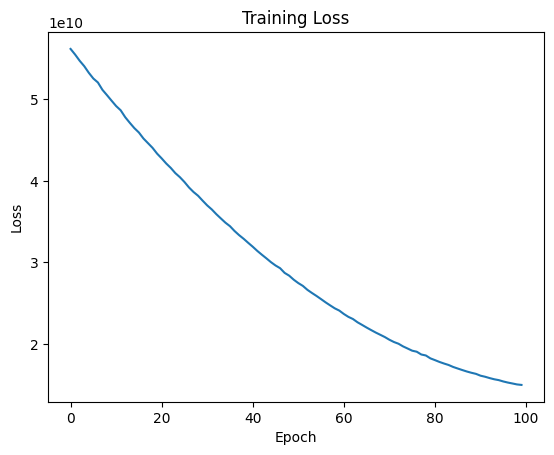

In [24]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')